In [187]:
using Pkg
Pkg.activate(".")

  Activating project at `c:\Users\fefif\Desktop\PhD\Progetti\MatrixProductBP.jl`


In [188]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using TensorTrains, TensorCast, Tullio, Random, IterTools, Plots
includet("bp_fourier.jl")

In [189]:
N = 4       # number of "neighbours"
# p = rand(N)
# J = rand(N)
J = fill(1.0, N)
D = 4       # original bond dimension
d = 4       # bond dimension for truncations
T = 5       # length of tensor train
q = (2, )   # number of values for the variables
K = 50      # number of frequencies
P = 2.0     # period for basis functions
σ = 1/50    # std for the approximation of the pdf for spins
svd_trunc = TruncBond(d)

rng = Xoshiro(14)
AA = [rand_tt(D, T, q...; rng) for i=1:N]

4-element Vector{TensorTrain{Float64, 3}}:
 TensorTrain{Float64, 3}([[0.07242010148636668 0.7222955991667338 0.0972361502618373 0.06250383501210599;;; 0.9107371384175941 0.6966311851426104 0.7359491678967808 0.35510548759455685], [0.9731890231032608 0.8629840155962346 0.32137013580916673 0.8539534611121387; 0.3333278970779533 0.6856259024489283 0.9228778860533595 0.8503386001259393; 0.3243248303835081 0.2456432818730856 0.2991885531995524 0.4699776833019397; 0.23640007638325422 0.5181241210780406 0.5461893182042901 0.14927837237638364;;; 0.45457782719008377 0.5545668650094746 0.20690404989551103 0.718593990859325; 0.02638819229910383 0.5107444306135452 0.2704576936708524 0.904325175482938; 0.1796737325446528 0.5942640975680719 0.8924709880419895 0.12243753341456398; 0.655961624692233 0.005939338658881743 0.5904921676247336 0.9319434612652726], [0.21003333316155948 0.08470505403873296 0.622987392796024 0.6822856008182175; 0.9430675565216217 0.07575391387820096 0.41561388076321737 0.8163

In [190]:
function aggregate(AA)
    function tensorprod(A₁, A₂)
        B = map(zip(A₁, A₂)) do (A₁ᵗ, A₂ᵗ)
            b = zeros(size(A₁ᵗ,1), size(A₂ᵗ,1), size(A₁ᵗ,2), size(A₂ᵗ,2), size(A₁ᵗ,3)+size(A₂ᵗ,3)-1)
            @tullio b[m1,m2,n1,n2,y] = A₁ᵗ[m1,n1,x₁] * A₂ᵗ[m2,n2,x₂] * (x₁+x₂-1==y)
            @cast _[(m1,m2),(n1,n2),y] := b[m1,m2,n1,n2,y]
        end
    end

    B = [copy(Aᵗ) for Aᵗ in AA[1]]
    for i in 2:length(AA)
        B = tensorprod(B,[A for A in AA[i]])
    end

    return TensorTrain(B)
end
;

In [191]:
Py = aggregate(AA)

TensorTrain{Float64, 3}([[0.0017718533090261964 0.017671914581886678 … 0.03584559661742302 0.02304171083339616;;; 0.025895183096317533 0.05307692291357404 … 0.4012282091829631 0.2144237702029769;;; 0.04735095896827656 0.05387532464861509 … 1.1153600299570712 0.559335419445495;;; 0.024239008490433797 0.01971310165845619 … 1.0376951507691046 0.5068892292536099;;; 0.00160114455227046 0.0012247301443870237 … 0.2921496032986719 0.14096615888080147], [0.5678349839232434 0.5035327187101951 … 0.07131590494581418 0.18950256129893073; 0.19448969992990248 0.4000480523845131 … 0.20479772158249807 0.18870038009489623; … ; 0.006112396494420995 0.004629522609242274 … 0.006150465717717152 0.009661404483321768; 0.004455320292489498 0.0097648399526101 … 0.011228098939862173 0.0030687387665035053;;; 1.1769098388127543 1.1320123945367164 … 0.2944920939227652 0.8199918002972867; 0.32765506761466323 0.9402956976855189 … 0.773857526125107 0.8584117176794734; … ; 0.08367548367470845 0.07201081266022515 … 0.07

In [192]:
scale = N+2

Px_basis = [FourierTensorTrain_spin(A, K, scale, P, σ) for A in AA]
Py_basis = convolution(Px_basis, J, P; K, scale, svd_trunc)
Py_basis = [A[:,:,:,1] |> collect for A in Py_basis] |> FourierTensorTrain
# Py_basis = convolution(Px_basis, J, P, K=K, svd_trunc=TruncThresh(0.0))

FourierTensorTrain{Float64, 3}(OffsetArray{ComplexF64, 3, Array{ComplexF64, 3}}[[-0.00015142125044640819 + 0.00021229680474741741im 0.00019871358419316847 + 0.0012540457808742278im 0.0008596195546206055 - 0.0023994232149343857im 0.0010108022970112343 + 0.004154650820753823im;;; -5.780818023538551e-5 + 6.045158294343352e-5im 9.332797096869744e-5 + 0.0002775893528115432im 0.0008827922210183212 - 0.00020290563382746008im -0.00020621140452182417 - 0.003411926770883808im;;; -5.187678081599457e-6 - 1.3113680813396598e-5im -8.149916895863098e-5 - 0.00013956041801469854im 0.0003238398856288073 + 0.0006900042905259654im -0.0004405954530372758 - 0.0032599039121608037im;;; … ;;; -5.187678081599546e-6 + 1.3113680813395946e-5im -8.149916895863197e-5 + 0.000139560418014687im 0.00032383988562849277 - 0.0006900042905262257im -0.0004405954530371101 + 0.00325990391216101im;;; -5.7808180235380615e-5 - 6.045158294343412e-5im 9.332797096848369e-5 - 0.00027758935281156893im 0.0008827922210200986 + 0.0002029

In [193]:
import MatrixProductBP: marginalize
function marginalize(A::MPEM2{F}, var) where F
    if var==1
        return MPEM1{F}([@tullio b[m, n, xi] := a[m, n, xi, xj] for a in A]; z = A.z)
    elseif var==2
        return MPEM1{F}([@tullio b[m, n, xj] := a[m, n, xi, xj] for a in A]; z = A.z)
    end
end;

In [194]:
marg = marginals(Py)
marg_basis = marginals(Py_basis,2.0)

t = 3
Pyt = marg[t]
Pyt_basis = marg_basis[t]
;

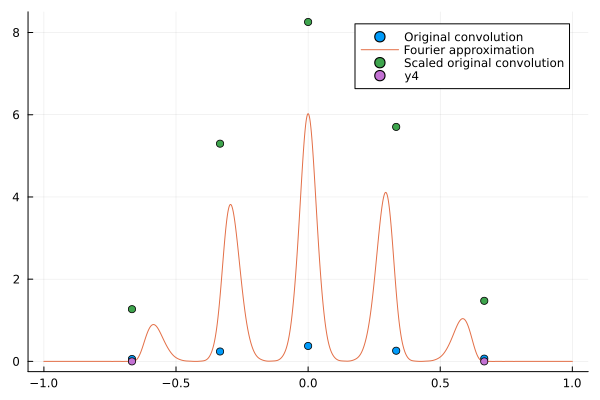

In [195]:
xscatter = range(-N/scale,N/scale,length=N+1)
yscatter = Pyt
xplot = collect(-1:0.001:1)
yplot = Pyt_basis.(xplot)
scatter(xscatter, yscatter, label="Original convolution")
plot!(xplot, yplot, label="Fourier approximation")
# ylims!(-1.5,8.5)

height = 22
scatter!(xscatter, yscatter.*height, label="Scaled original convolution")
scatter!([-N/scale,N/scale], [0,0])